<a href="https://colab.research.google.com/github/Ketan0110/Employee-Attrition-Prediction-Model/blob/main/Sentence_Autocompletion_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Implementation

# **Text Preprocessing**

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional,Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import nltk
import re

In [ ]:
# Specify the filename
input_file = '/content/holmes.txt'

# Read the contents of the file
with open(input_file, 'r', encoding='utf-8') as infile:
    data = infile.read()

In [ ]:
data[:101] # view first few characters

"*Project Gutenberg's Etext of Tom Swift And His Submarine Boat*\n\n#4 in the Victor Appleton's Tom Swif"

In [ ]:
# Limit data to 500000 characters
data = data[:500000]

# Clean Text

In [ ]:

def remove_emojis_and_special_characters(text):

    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F700-\U0001F77F"
                               u"\U0001F780-\U0001F7FF"
                               u"\U0001F800-\U0001F8FF"
                               u"\U0001F900-\U0001F9FF"
                               u"\U0001FA00-\U0001FA6F"
                               u"\U0001FA70-\U0001FAFF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)


    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)


    text = re.sub(' +', ' ', text)

    return text

In [ ]:

def preprocess_pipeline(data) -> 'list':
    sentences = data.split('\n')
    for i in range(len(sentences)):
        sentences[i] = remove_emojis_and_special_characters(sentences[i])
    sentences = [s.strip() for s in sentences]
    sentences = [s for s in sentences if len(s) > 0]

    tokenized = []
    for sentence in sentences:

        sentence = sentence.lower()
        tokenized.append(sentence)
    return tokenized


tokenized_sentences = preprocess_pipeline(data)

In [ ]:


tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(tokenized_sentences)
total_words = len(tokenizer.word_index) + 1



input_sequences = []
for line in tokenized_sentences:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        input_sequences.append(n_gram_sequence)


max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [ ]:

X,labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words) #contains one hot encoded version of labels

In [ ]:

from sklearn.model_selection import train_test_split
X_train_temp, X_val_test, y_train_temp, y_val_test = train_test_split(X, ys, test_size=0.1, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Train LSTM Model

In [ ]:

model = Sequential()
model.add(Embedding(total_words, 100))
model.add(LSTM(50))
model.add(Dense(total_words, activation='softmax'))

adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


history = model.fit(X_train_temp, y_train_temp, epochs=50, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.0896 - loss: 6.3403 - val_accuracy: 0.1307 - val_loss: 5.7126
Epoch 2/50
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - accuracy: 0.1477 - loss: 5.2697 - val_accuracy: 0.1459 - val_loss: 5.6499
Epoch 3/50
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.1674 - loss: 4.8615 - val_accuracy: 0.1436 - val_loss: 5.7305
Epoch 4/50
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.1783 - loss: 4.6255 - val_accuracy: 0.1434 - val_loss: 5.8556
Epoch 5/50
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.1916 - loss: 4.4201 - val_accuracy: 0.1531 - val_loss: 6.0219
Epoch 6/50
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.1987 - loss: 4.3078 - val_accuracy: 0.1484 - val_loss: 6.1748
Epoch 7/50
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.2097 - loss: 4.1999 - val_accuracy: 0.1519 - val_loss: 6.3573
Epoch 8/50
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.2118 - loss: 4

# Save Models (Weights and biases)

In [ ]:

from tensorflow.keras.models import model_from_json

model_json = model.to_json()
with open("lstm_model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:

from tensorflow.keras.models import model_from_json

with open("lstm_model.json", "r") as json_file:
    loaded_model_json = json_file.read()


loaded_model = model_from_json(loaded_model_json)

print("Model architecture loaded successfully from JSON file.")

Model architecture loaded successfully from JSON file.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


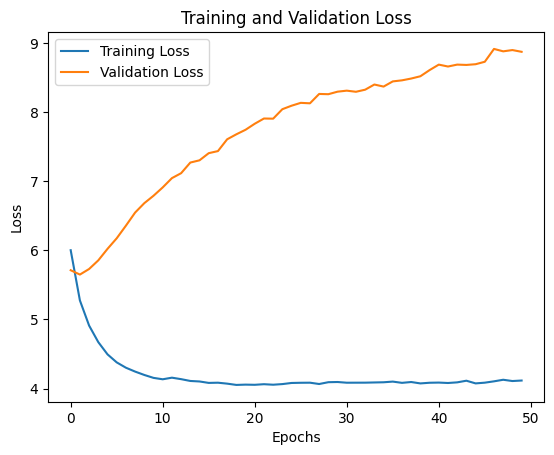

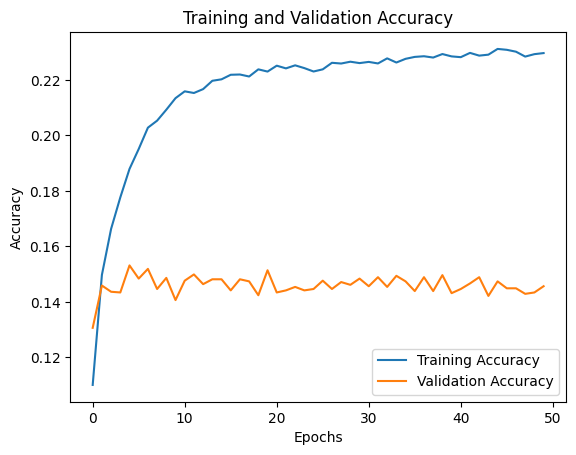

In [ ]:


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Inferences

In [ ]:

model.save("lstm_autocomplete_model.h5")

print("Model saved successfully!")

Model saved successfully!


In [ ]:
def predict_top_five_words(model, tokenizer, seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    top_five_indexes = np.argsort(predicted[0])[::-1][:5]
    top_five_words = []
    for index in top_five_indexes:
        for word, idx in tokenizer.word_index.items():
            if idx == index:
                top_five_words.append(word)
                break
    return top_five_words


In [ ]:
from tensorflow.keras.models import load_model


model = load_model("lstm_autocomplete_model.h5")

print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from IPython.display import display, HTML

def predict_top_five_words(model, tokenizer, seed_text, max_sequence_len):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    top_five_indexes = np.argsort(predicted[0])[::-1][:5]

    index_word = {idx: word for word, idx in tokenizer.word_index.items()}
    top_five_words = [index_word.get(i, "<?>") for i in top_five_indexes]

    return top_five_words

def display_top_five_predictions(seed_text, model, tokenizer, max_sequence_len):
    top_words = predict_top_five_words(model, tokenizer, seed_text, max_sequence_len)

    html_output = f"""
    <h3>Seed Text: <em>{seed_text}</em></h3>
    <h4>Top 5 Predicted Next Words:</h4>
    <ol>
        {''.join(f"<li>{seed_text} <strong>{word}</strong></li>" for word in top_words)}
    </ol>
    """
    display(HTML(html_output))

In [ ]:
seed_text = "the fast"
display_top_five_predictions(seed_text, model, tokenizer, max_sequence_len)